# Using a domain map to model a fault

We discussed the use of a binary map to delineate regions in which different potential fields are "active" - e.g. to model unconformities or faults. Let's have a look at a simple fault example here.

In [26]:
import numpy as np
from scipy.interpolate import Rbf

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

# for least square solution to line
from numpy.linalg import lstsq

plt.rcParams['figure.figsize'] = (8., 6.)
plt.rcParams['font.size'] = 16.

## Create randomized data

As before, we will include a data generation procedure, in order to be able to test the effect of varying resolution on model results below.

In [27]:
n_pts = 10 # Points per layer

# Linear functions for line data
l1 = lambda x : 0.25*x + 30
l2 = lambda x : 0.25*x + 40
l3 = lambda x : 0.25*x + 50

# set seed for reproducibility
np.random.seed(123)
# sampling points
l1_pts_x = np.random.uniform(0,90,n_pts)
l1_pts_y = l1(l1_pts_x)
l2_pts_x = np.random.uniform(0,90,n_pts)
l2_pts_y = l2(l2_pts_x)
l3_pts_x = np.random.uniform(0,90,n_pts)
l3_pts_y = l3(l3_pts_x)

## Define fault

In order to define a fault, we will model it here as a line through two points:

In [28]:
fault_point_1 = (40,60)
fault_point_2 = (60,20)

In [29]:
x_coords, y_coords = [40,60], [60,20] # zip(*points)
A = np.vstack([x_coords, np.ones(len(x_coords))]).T
m, c = lstsq(A, y_coords, rcond=None)[0]
print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

Line Solution is y = -2.0000000000000013x + 140.00000000000014


We next define the effect of this fault on the surrounding points as an offset:

In [30]:
offset = 10 # offset of block on right side of fault
f = lambda x : m*x + c

# Create filters to determine points on each side of fault
filter_l1 = f(l1_pts_x) < l1_pts_y
filter_l2 = f(l2_pts_x) < l2_pts_y
filter_l3 = f(l3_pts_x) < l3_pts_y

# create copies of arrays to avoid confusion...
l1_pts_x_fault = l1_pts_x.copy()
l1_pts_y_fault = l1_pts_y.copy()
l2_pts_x_fault = l2_pts_x.copy()
l2_pts_y_fault = l2_pts_y.copy()
l3_pts_x_fault = l3_pts_x.copy()
l3_pts_y_fault = l3_pts_y.copy()

# Adjust y-values
l1_pts_y_fault[filter_l1] -= offset
l2_pts_y_fault[filter_l2] -= offset
l3_pts_y_fault[filter_l3] -= offset
# Adjust x-values
l1_pts_x_fault[filter_l1] -= 1/m*offset
l2_pts_x_fault[filter_l2] -= 1/m*offset
l3_pts_x_fault[filter_l3] -= 1/m*offset

(0, 100)

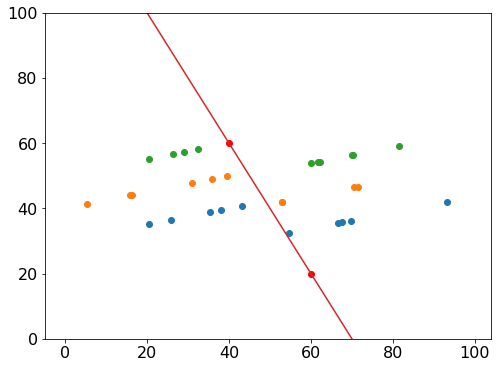

In [31]:
f = lambda x : m*x + c

plt.plot(l1_pts_x_fault, l1_pts_y_fault, 'o')
plt.plot(l2_pts_x_fault, l2_pts_y_fault, 'o')
plt.plot(l3_pts_x_fault, l3_pts_y_fault, 'o')

plt.plot(x_coords, y_coords, 'ro')
xrange = np.arange(100)
plt.plot(xrange, f(xrange))

plt.ylim([0,100])

# plt.axis('equal')

_Note_: this is actually a very primitive definition of a line: we use here a so-called "kinematic model" as we explicitly define the fault position and the effect on the surrounding data.

## Create domain map for fault

### Interpolate scalar field for fault domains

As a first step, we will create a domain map on the basis of the fault. Towards this aim, we will also generate a scalar field interpolation for the fault itself:

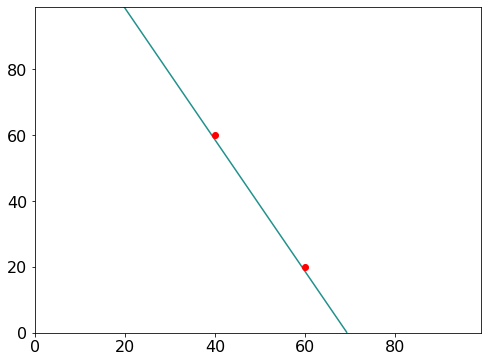

In [32]:
# set up grid
ti = np.linspace(0, 100, 100)
XI, YI = np.meshgrid(ti, ti)
# trick: add points at lower left and upper right to obtain gradients in field
# (otherwise, we would simply interpolate zeros...)
x_coords_ext = np.hstack([x_coords, 0, 100])
y_coords_ext = np.hstack([y_coords, 0, 100])
rbf = Rbf(x_coords_ext, y_coords_ext, [0,0,-1,1], function="gaussian", epsilon=1000)
ZI = rbf(XI, YI)
plt.contour(ZI, 0)
plt.plot(x_coords, y_coords, 'ro')
# plt.colorbar()

### Extract domain map

In this example, we have two domains, one on each side of the fault. In this case, we have a simple boolean map (for generalizations, we can extend it to an integer map for multiple domains):

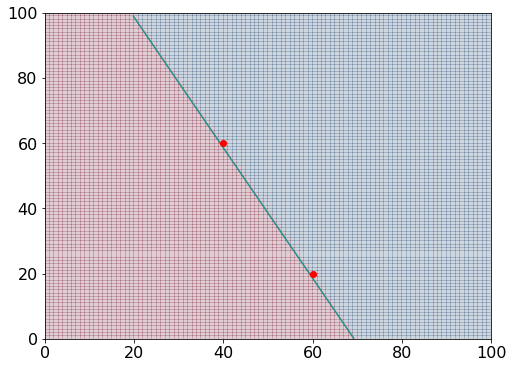

In [33]:
fault_domains = np.zeros_like(ZI)
fault_domains[ZI>0] = 1
plt.pcolor(fault_domains, cmap='RdBu', alpha=0.2)
plt.contour(ZI, 0)
plt.plot(x_coords, y_coords, 'ro')

## Interpolate fields on both side of fault

Now that we have the domains defined, we can interpolate the scalar fields on both sides of the fault. We will here use a simple "divide-and-conquer" method, i.e.:

- separate point data sets according to domain in which points are in (note: we can also very effectively use the fault scalar field for this purpose);
- interpolate a separate scalar field for each domain;
- finally, create one combined scalar field with values according to each domain;
- extract isosurfaces using contouring method (marching squares).

### Separate points on both sides

Let's start with the separation of points:

In [37]:
# left domain
l1_pts_x_left = l1_pts_x_fault[np.where(rbf(l1_pts_x_fault, l1_pts_y_fault) < 0)]
l1_pts_y_left = l1_pts_y_fault[np.where(rbf(l1_pts_x_fault, l1_pts_y_fault) < 0)]
l2_pts_x_left = l2_pts_x_fault[np.where(rbf(l2_pts_x_fault, l2_pts_y_fault) < 0)]
l2_pts_y_left = l2_pts_y_fault[np.where(rbf(l2_pts_x_fault, l2_pts_y_fault) < 0)]
l3_pts_x_left = l3_pts_x_fault[np.where(rbf(l3_pts_x_fault, l3_pts_y_fault) < 0)]
l3_pts_y_left = l3_pts_y_fault[np.where(rbf(l3_pts_x_fault, l3_pts_y_fault) < 0)]
# right domain
l1_pts_x_right = l1_pts_x_fault[np.where(rbf(l1_pts_x_fault, l1_pts_y_fault) > 0)]
l1_pts_y_right = l1_pts_y_fault[np.where(rbf(l1_pts_x_fault, l1_pts_y_fault) > 0)]
l2_pts_x_right = l2_pts_x_fault[np.where(rbf(l2_pts_x_fault, l2_pts_y_fault) > 0)]
l2_pts_y_right = l2_pts_y_fault[np.where(rbf(l2_pts_x_fault, l2_pts_y_fault) > 0)]
l3_pts_x_right = l3_pts_x_fault[np.where(rbf(l3_pts_x_fault, l3_pts_y_fault) > 0)]
l3_pts_y_right = l3_pts_y_fault[np.where(rbf(l3_pts_x_fault, l3_pts_y_fault) > 0)]



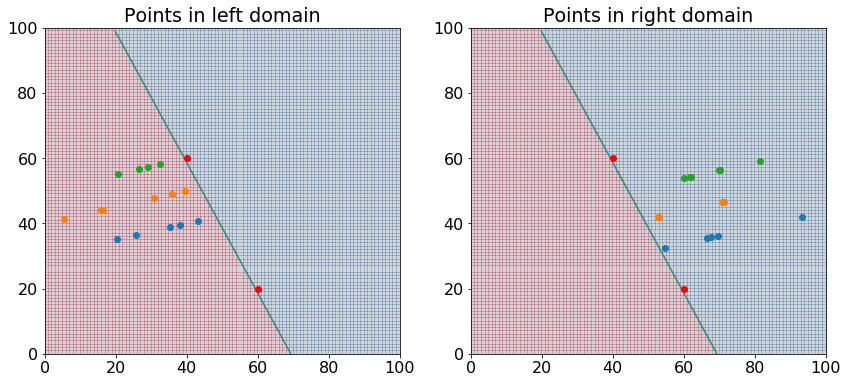

In [38]:
fit, axes = plt.subplots(1,2, figsize=(14,6))

axes[0].pcolor(fault_domains, cmap='RdBu', alpha=0.2)
axes[0].contour(ZI, 0)
axes[0].plot(x_coords, y_coords, 'ro')
# plot points on left side
axes[0].plot(l1_pts_x_left, l1_pts_y_left, 'o')
axes[0].plot(l2_pts_x_left, l2_pts_y_left, 'o')
axes[0].plot(l3_pts_x_left, l3_pts_y_left, 'o')
axes[0].set_title("Points in left domain")

axes[1].pcolor(fault_domains, cmap='RdBu', alpha=0.2)
axes[1].contour(ZI, 0)
axes[1].plot(x_coords, y_coords, 'ro')
# plot points on right side
axes[1].set_title("Points in right domain")
axes[1].plot(l1_pts_x_right, l1_pts_y_right, 'o')
axes[1].plot(l2_pts_x_right, l2_pts_y_right, 'o')
axes[1].plot(l3_pts_x_right, l3_pts_y_right, 'o');

### Interpolate scalar fields for each set of points

We now interpolate one scalar field for the set of points in each domain:

In [39]:
# left domain

# combine data in arrays
x = np.hstack([l1_pts_x_left, l2_pts_x_left, l3_pts_x_left])
y = np.hstack([l1_pts_y_left, l2_pts_y_left, l3_pts_y_left])

# give points values
z = np.hstack([np.ones(len(l1_pts_x_left))*10, 
               np.ones(len(l2_pts_x_left))*20, 
               np.ones(len(l3_pts_x_left))*30])

# use RBF
rbf = Rbf(x, y, z, function="multiquadric", epsilon=50)
ZI_left = rbf(XI, YI)

In [40]:
# right domain

# combine data in arrays
x = np.hstack([l1_pts_x_right, l2_pts_x_right, l3_pts_x_right])
y = np.hstack([l1_pts_y_right, l2_pts_y_right, l3_pts_y_right])

# give points values
z = np.hstack([np.ones(len(l1_pts_x_right))*10, 
               np.ones(len(l2_pts_x_right))*20, 
               np.ones(len(l3_pts_x_right))*30])

# use RBF
rbf = Rbf(x, y, z, function="multiquadric", epsilon=50)
ZI_right = rbf(XI, YI)

Let's create a plot for both interpolated fields:

NameError: name 'ZI_comb' is not defined

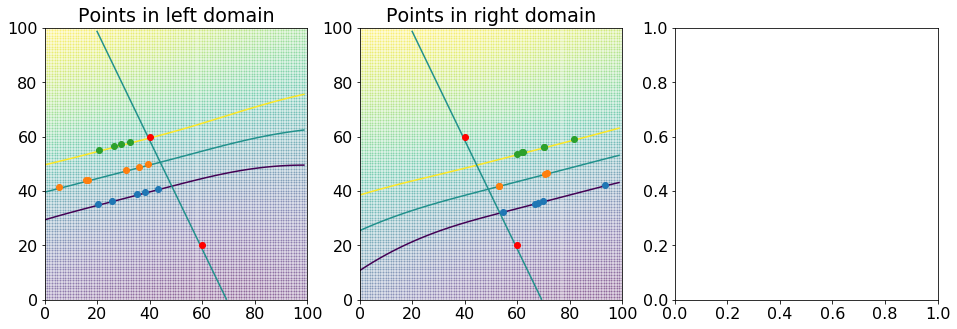

In [41]:
fit, axes = plt.subplots(1,3, figsize=(16,5))

# Left field

axes[0].pcolor(ZI_left, cmap='viridis', alpha=0.2)
axes[0].contour(ZI_left, [10,20,30])
axes[0].contour(ZI, 0)
axes[0].plot(x_coords, y_coords, 'ro')
# plot points on left side
axes[0].plot(l1_pts_x_left, l1_pts_y_left, 'o')
axes[0].plot(l2_pts_x_left, l2_pts_y_left, 'o')
axes[0].plot(l3_pts_x_left, l3_pts_y_left, 'o')
axes[0].set_title("Points in left domain")

# Right field

axes[1].pcolor(ZI_right, cmap='viridis', alpha=0.2)
axes[1].contour(ZI_right, [10,20,30])
axes[1].contour(ZI, 0)
axes[1].plot(x_coords, y_coords, 'ro')
# plot points on right side
axes[1].set_title("Points in right domain")
axes[1].plot(l1_pts_x_right, l1_pts_y_right, 'o')
axes[1].plot(l2_pts_x_right, l2_pts_y_right, 'o')
axes[1].plot(l3_pts_x_right, l3_pts_y_right, 'o');

# Combined field

axes[2].pcolor(ZI_comb, cmap='viridis', alpha=0.2)
axes[2].contour(ZI_comb, [10,20,30])
axes[2].contour(ZI, 0)
axes[2].plot(x_coords, y_coords, 'ro')
# plot all points
axes[2].set_title("Combined field and all points")
axes[2].plot(l1_pts_x_fault, l1_pts_y_fault, 'o')
axes[2].plot(l2_pts_x_fault, l2_pts_y_fault, 'o')
axes[2].plot(l3_pts_x_fault, l3_pts_y_fault, 'o')


In [ ]:
fit, axes = plt.subplots(1,2, figsize=(14,6))

axes[0].pcolor(ZI_left, cmap='viridis', alpha=0.2)
axes[0].contour(ZI_left, [10,20,30])
axes[0].contour(ZI, 0)
axes[0].plot(x_coords, y_coords, 'ro')
# plot points on left side
axes[0].plot(l1_pts_x_left, l1_pts_y_left, 'o')
axes[0].plot(l2_pts_x_left, l2_pts_y_left, 'o')
axes[0].plot(l3_pts_x_left, l3_pts_y_left, 'o')
axes[0].set_title("Points in left domain")

axes[1].pcolor(ZI_right, cmap='viridis', alpha=0.2)
axes[1].contour(ZI_right, [10,20,30])
axes[1].contour(ZI, 0)
axes[1].plot(x_coords, y_coords, 'ro')
# plot points on right side
axes[1].set_title("Points in right domain")
axes[1].plot(l1_pts_x_right, l1_pts_y_right, 'o')
axes[1].plot(l2_pts_x_right, l2_pts_y_right, 'o')
axes[1].plot(l3_pts_x_right, l3_pts_y_right, 'o');

## Combine scalar fields

If we chose a reasonable interpolation, then we now have interpolated scalar fields with reasonable fits on both sides of the fault. In the next step, we will combine both fields, according to the (fault) domain map. Note that this simply means that we use map the scalar field values according to each domain:

In [42]:
ZI

array([[-1.        , -0.98521418, -0.97043676, ...,  0.38176324,
         0.39531829,  0.40885653],
       [-0.99208612, -0.97731289, -0.96254809, ...,  0.38837501,
         0.40191592,  0.41544   ],
       [-0.98418031, -0.96941972, -0.95466756, ...,  0.39497564,
         0.40850237,  0.42201227],
       ...,
       [-0.27713475, -0.2637154 , -0.25030619, ...,  0.96527927,
         0.97734006,  0.98938316],
       [-0.27022593, -0.25682205, -0.24342833, ...,  0.97062815,
         0.9826724 ,  0.99469895],
       [-0.26332958, -0.24994121, -0.236563  , ...,  0.97596233,
         0.98799002,  1.        ]])

In [ ]:
ZI_comb = np.zeros_like(ZI_left)

ZI_comb[ZI < 0] = ZI_left[ZI < 0]
ZI_comb[ZI > 0] = ZI_right[ZI > 0]

## Summary

- We obtained a geological model for a fault offseting a set of layers. As an example, we used a simple stack of horizontal layers - but the approach can directly be applied to more complex geological settings, as long as they are modeled with an implicit approach.
- Note also, that this method generalises directly to higher dimensions, especially for 3-D interpolations.
- Finally, for more complex settings (e.g. multiple fault blocks, combined faults with unconformities, etc.), the method can be extended with additional domain maps - which then need to be combined appropriately, reflecting the geological evolution of events.

